In [34]:
from datetime import datetime

import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline#, FeatureUnions
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score


In [7]:
DATE = datetime.today().strftime("%Y_%m_%d")
PATH = '/Users/schwarls37/TAKEHOMES/FTFCU/'
FILE = 'indian_liver_patient.csv'

## 1. How many rows and columns are there in the data set?


- n = 583 = 416(y=1;Dataset=1)+167(y=0;Dataset=2) = 441(male)+142(female)
- In addition to the outcome indicator of liver patient (liver disease) or not (no disease) there are 10 Feature columns
    - Age of the patient
    - Gender of the patient
    - Total Bilirubin
    - Direct Bilirubin
    - Alkaline Phosphotase
    - Alamine Aminotransferase
    - Aspartate Aminotransferase
    - Total Protiens
    - Albumin
    - Albumin and Globulin Ratio 

In [8]:
ILPR = pd.read_csv(PATH+FILE)
ILPR.Gender = (ILPR.Gender == 'Male')
ILPR.shape

(583, 11)

## 2. Identify and impute NAs to the mean


In [9]:
missingness_counts = ILPR.isnull().sum(axis=0).to_frame('n missing before').T

fill_value = ILPR['Albumin_and_Globulin_Ratio'].mean()
ILPR['Albumin_and_Globulin_Ratio'].fillna(fill_value, inplace=True)

missingness_counts = missingness_counts.append(
                     ILPR.isnull().sum(axis=0).to_frame('n missing after').T)

missingness_counts

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
n missing before,0,0,0,0,0,0,0,0,0,4,0
n missing after,0,0,0,0,0,0,0,0,0,0,0


## 3. Provide descriptives by health condition


In [10]:
ILPR.groupby(ILPR.Dataset).describe()


Age                                                     \
         count       mean        std  min   25%   50%   75%   max   
Dataset                                                             
1        416.0  46.153846  15.654412  7.0  34.0  46.0  58.0  90.0   
2        167.0  41.239521  16.999366  4.0  28.0  40.0  55.0  85.0   

        Alamine_Aminotransferase                                           \
                           count       mean         std   min   25%   50%   
Dataset                                                                     
1                          416.0  99.605769  212.768472  12.0  25.0  41.0   
2                          167.0  33.652695   25.060392  10.0  20.0  27.0   

                      Albumin                                                 \
          75%     max   count      mean       std  min  25%  50%    75%  max   
Dataset                                                                        
1        76.5  2000.0   416.0  3.060577  0.786595  0.9  2.5  3.0  3.625  5.5   
2        37.5   181.0   167.0  3.344311  0.783690  1.4  2.9  3.4  4.000  5.0   

        Albumin_and_Globulin_Ratio                                           \
                             count      mean       std   min  25%  50%  75%   
Dataset                                                                       
1                            416.0  0.914337  0.325374  0.30  0.7  0.9  1.1   
2                            167.0  1.028588  0.285658  0.37  0.9  1.0  1.2   

             Alkaline_Phosphotase                                              \
         max                count        mean         std   min    25%    50%   
Dataset                                                                         
1        2.8                416.0  319.007212  268.307911  63.0  186.0  229.0   
2        1.9                167.0  219.754491  140.986262  90.0  161.5  186.0   

                        Aspartate_Aminotransferase                         \
            75%     max                      count        mean        std   
Dataset                                                                     
1        315.25  2110.0                      416.0  137.699519  337.38998   
2        213.00  1580.0                      167.0   40.688623   36.41162   

                                           Direct_Bilirubin            \
          min    25%   50%     75%     max            count      mean   
Dataset                                                                 
1        11.0  29.75  52.5  108.75  4929.0            416.0  1.923558   
2        10.0  21.00  29.0   43.50   285.0            167.0  0.396407   

                                             Total_Bilirubin            \
              std  min  25%  50%   75%   max           count      mean   
Dataset                                                                  
1        3.206901  0.1  0.2  0.5  1.80  19.7           416.0  4.164423   
2        0.519255  0.1  0.2  0.2  0.35   3.6           167.0  1.142515   

                                              Total_Protiens            \
              std  min  25%  50%    75%   max          count      mean   
Dataset                                                                  
1        7.144831  0.4  0.8  1.4  3.625  75.0          416.0  6.459135   
2        1.004472  0.5  0.7  0.8  1.100   7.3          167.0  6.543114   

                                             
              std  min  25%   50%  75%  max  
Dataset                                      
1        1.094659  2.7  5.7  6.55  7.2  9.6  
2        1.063042  3.7  5.9  6.60  7.3  9.2

## 4. Provide graphical representation of feature distributions by health condition


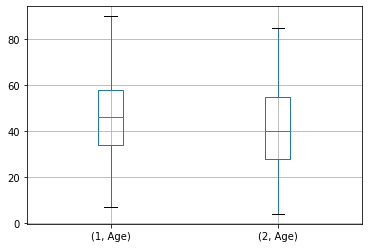

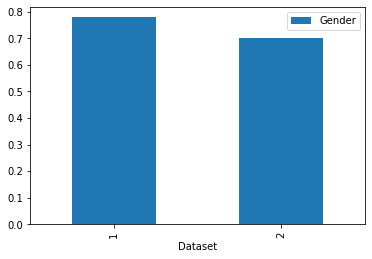

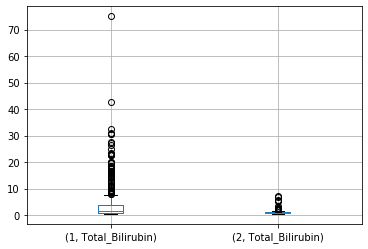

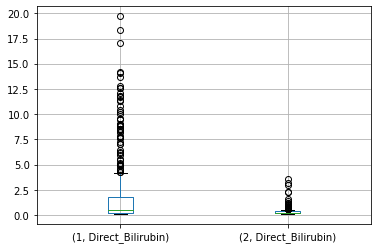

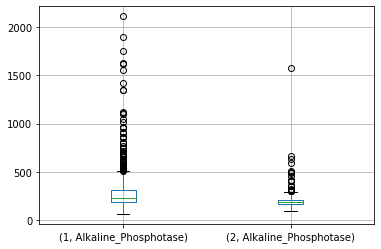

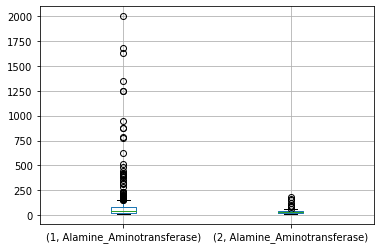

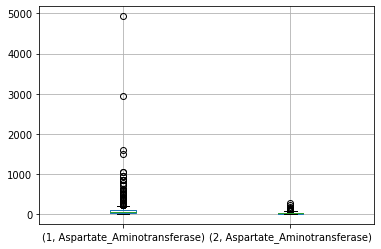

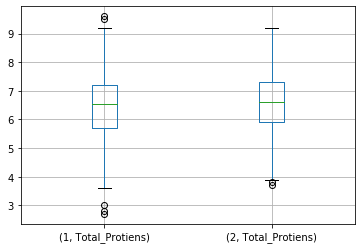

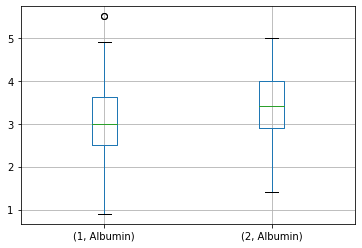

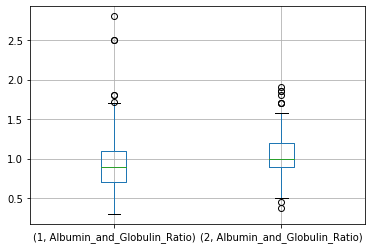

In [11]:
for col in ILPR.columns[:-1]:
    if ILPR.dtypes[col]=='bool':
        ILPR[[col]].groupby(ILPR.Dataset).mean().plot.bar()
    else:
        ILPR[[col]].groupby(ILPR.Dataset).boxplot(subplots=False)
    plt.show()


## 5. Check statistical significance of gender on health condition


In [12]:

CoTa = pd.crosstab(ILPR.Dataset, ILPR.Gender)
display(CoTa)

stats.fisher_exact(CoTa)

Gender,False,True
Dataset,,
1,92,324
2,50,117


(0.6644444444444444, 0.054600832857131784)

## 6. Show your work on feature engineering and correlation analysis 
- There exists notable multicolinearity within the "Albumin/Proteins" complex:
    - Total_Protiens
    - Albumin
    - Albumin_and_Globulin_Ratio

<Figure size 432x288 with 0 Axes>

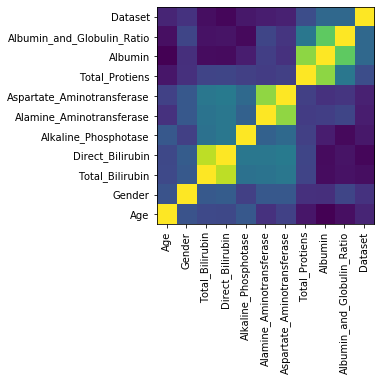

In [13]:
# A: correlation matrix

plt.set_cmap('viridis')
fig, ax = plt.subplots()
ax.imshow(ILPR.corr())

ax.set_yticks(range(ILPR.shape[1]))
ax.set_yticklabels(ILPR.columns)
ax.set_xticks(range(ILPR.shape[1]))
ax.set_xticklabels(ILPR.columns, rotation=90)
ax.set_ylim([-.5,ILPR.shape[1]-.5])
_=ax.set_xlim([-.5,ILPR.shape[1]-.5])

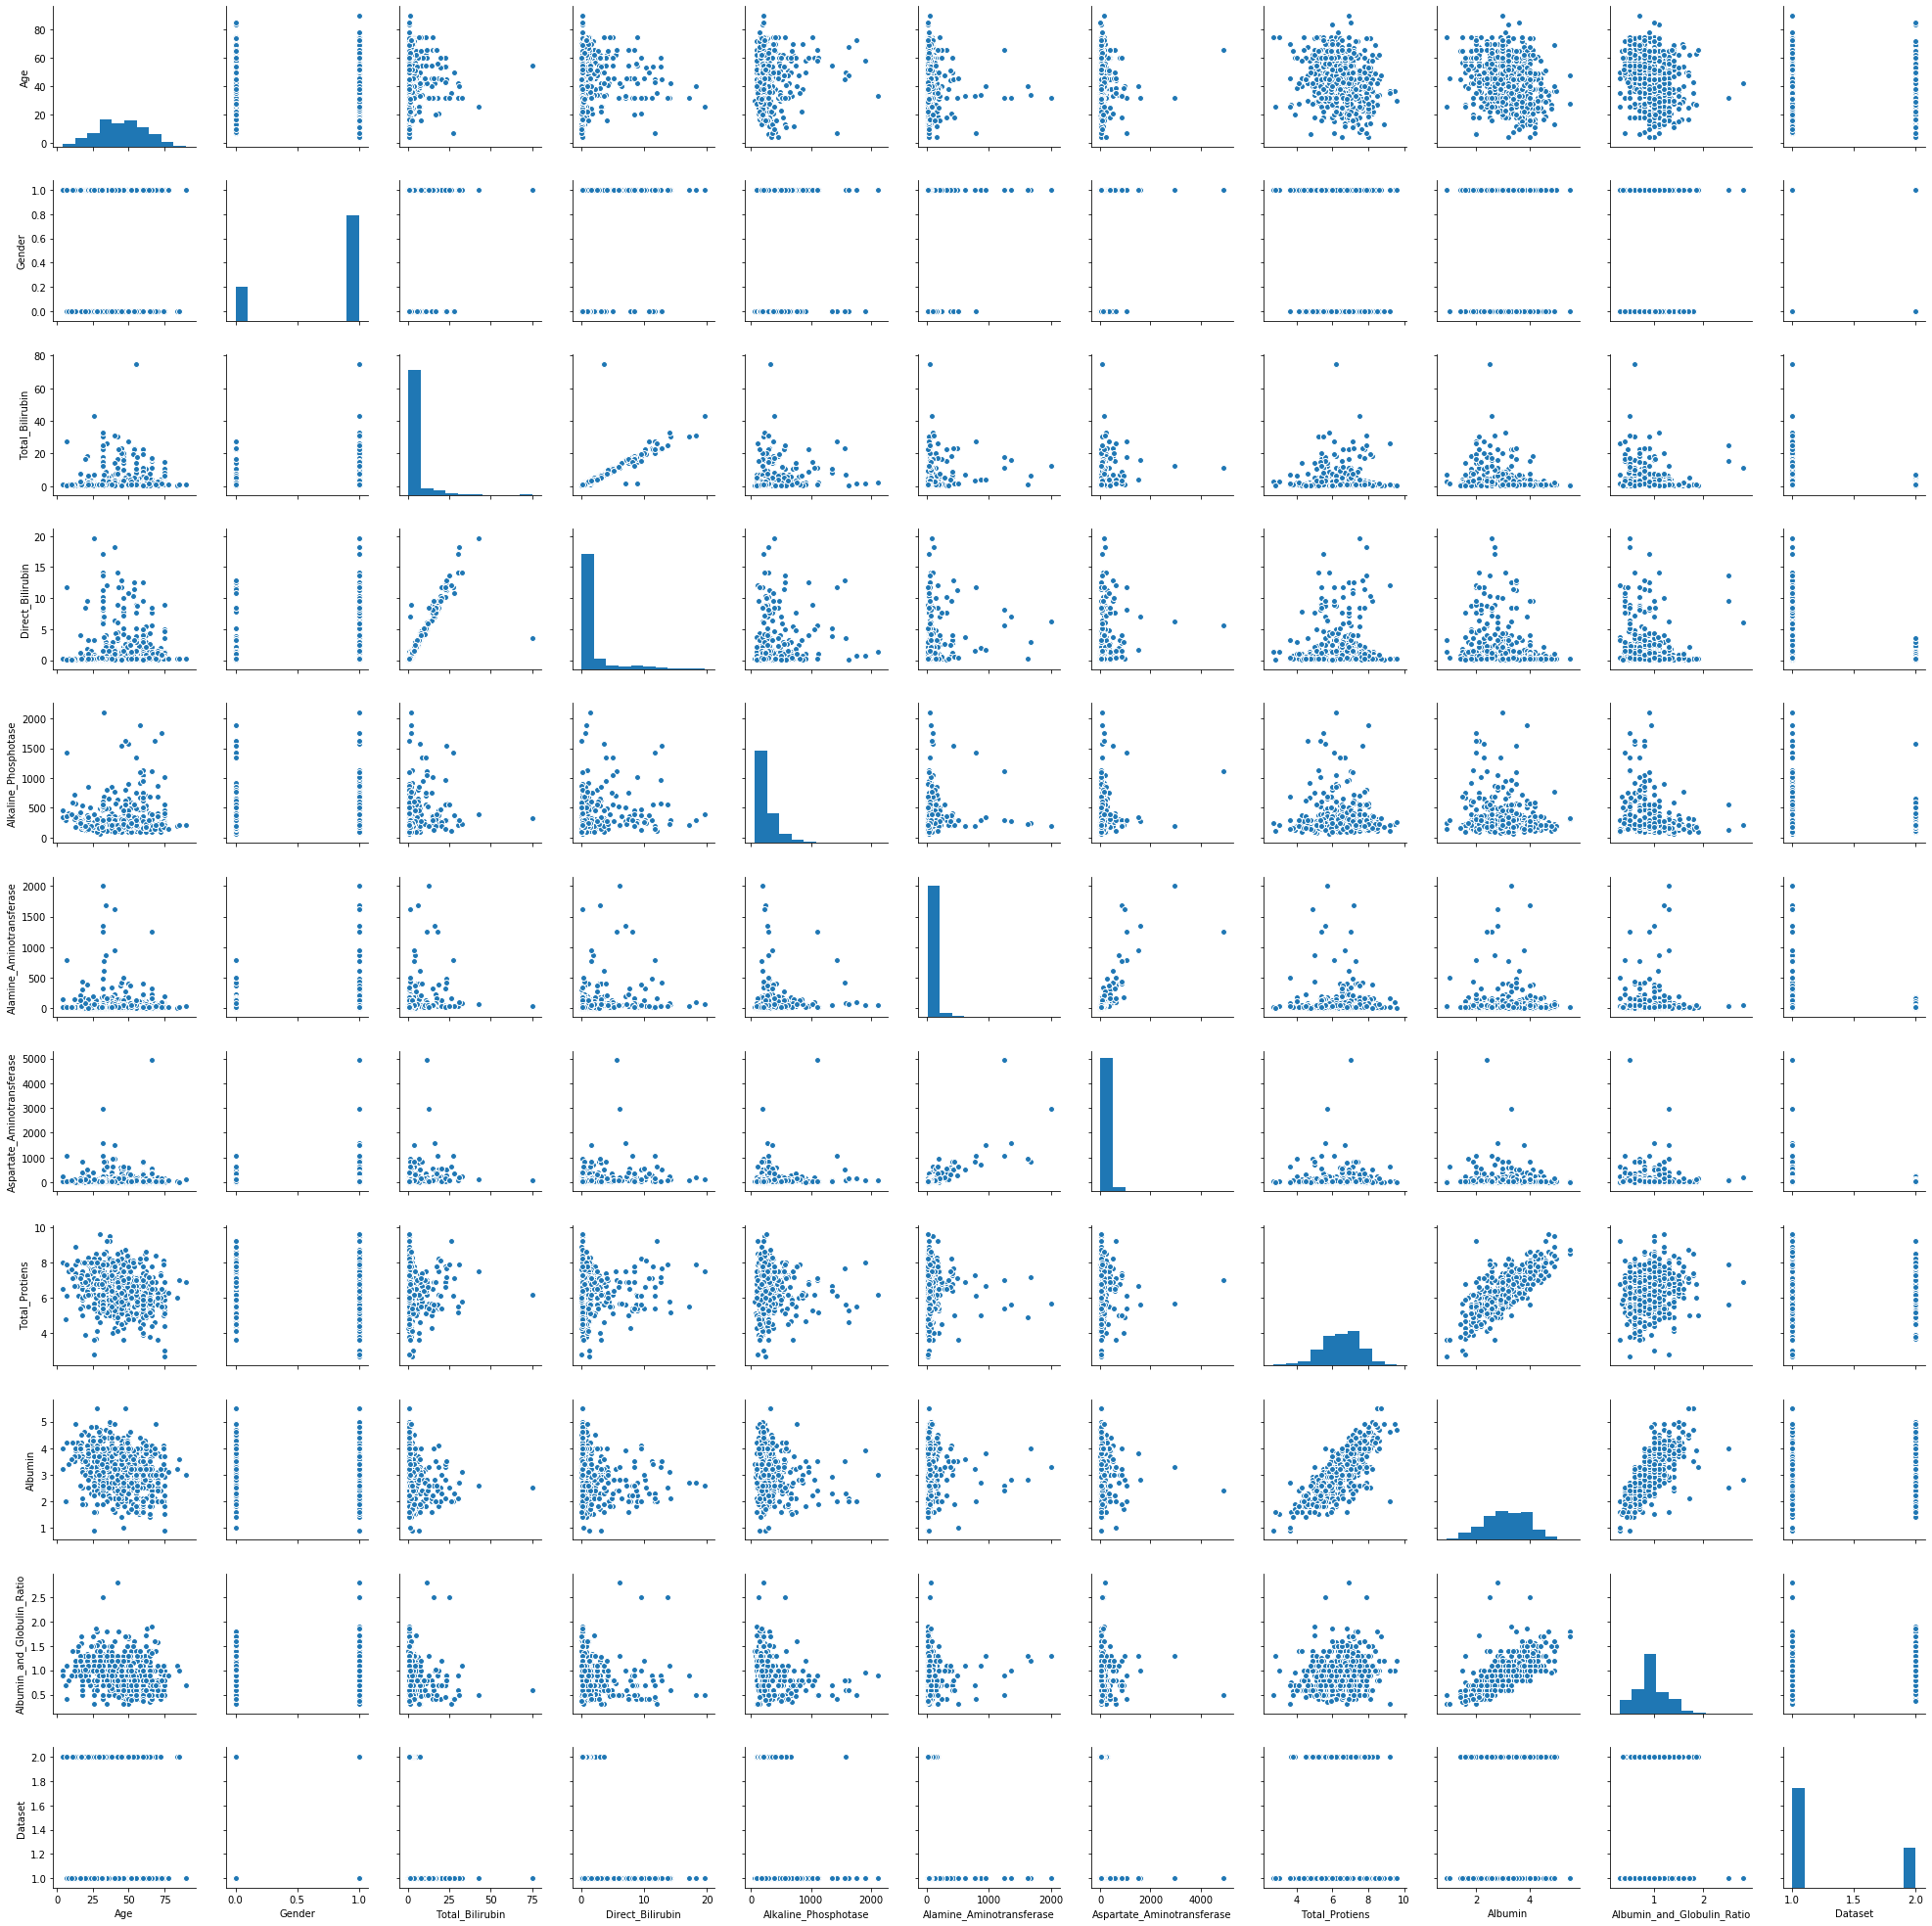

In [14]:
# B: pairwise plots

sns.pairplot(ILPR)

In [15]:
# C: Variance Inflation Factor

X = ILPR.iloc[:,:-1].values.astype(float)
X_columns = ILPR.columns[:-1]
VIFs = {}

for i,col in enumerate(X_columns):
    VIF = variance_inflation_factor(X, i)
    VIFs[col] = variance_inflation_factor(X, i)
    print(col,VIF)


Age 7.8130771068150535
Gender 4.087526397416078
Total_Bilirubin 5.479227683000851
Direct_Bilirubin 5.736207208634572
Alkaline_Phosphotase 2.650280091895184
Alamine_Aminotransferase 3.3086492439271162
Aspartate_Aminotransferase 3.192720842185779
Total_Protiens 101.86089978199087
Albumin 133.05571531122322
Albumin_and_Globulin_Ratio 25.717648539399047


## 7. Show your work on pre-processing


In [16]:
# final hold out test set

final_hold_out = ILPR[ILPR.Dataset==1].sample(n=75).index.tolist()+\
                 ILPR[ILPR.Dataset==2].sample(n=25).index.tolist()
final_hold_out = ILPR.index.isin(final_hold_out)
ILPR_FHO = ILPR[final_hold_out]
ILPR_WIP = ILPR[~final_hold_out]
ILPR_FHO.shape, ILPR_WIP.shape

((100, 11), (483, 11))

In [17]:
# Final Test Data

ILPR_X_FHO = ILPR_FHO[['Gender','Age']+list(ILPR.columns)[2:-1]]
ILPR_X_FHO = ILPR_X_FHO.values.astype(float)
ILPR_Y_FHO = (ILPR_FHO['Dataset']==1).values.astype(int)


In [18]:
# Model Fitting Data

ILPR_X = ILPR_WIP[['Gender','Age']+list(ILPR.columns)[2:-1]]
ILPR_X = ILPR_X.values.astype(float)
ILPR_Y = (ILPR_WIP['Dataset']==1).values.astype(int)
ILPR_X


array([[ 0.  , 65.  ,  0.7 , ...,  6.8 ,  3.3 ,  0.9 ],
       [ 1.  , 62.  ,  7.3 , ...,  7.  ,  3.3 ,  0.89],
       [ 1.  , 72.  ,  3.9 , ...,  7.3 ,  2.4 ,  0.4 ],
       ...,
       [ 1.  , 40.  ,  0.6 , ...,  6.  ,  3.2 ,  1.1 ],
       [ 1.  , 52.  ,  0.8 , ...,  6.4 ,  3.2 ,  1.  ],
       [ 1.  , 31.  ,  1.3 , ...,  6.8 ,  3.4 ,  1.  ]])

In [19]:
# Feature Treatments

PL_Bool = Pipeline([('SimpleImputer',SimpleImputer(missing_values=np.nan, 
                                                   strategy='most_frequent'))])

# For Random Forest Model, and weighted KNN
PL_Cont_Imp = Pipeline([('SimpleImputer', SimpleImputer())])
RF_X =\
ColumnTransformer([("Bool_Impute", PL_Bool, [0]),
                   ("Cont_Impute", PL_Cont_Imp, slice(1,10))])

# For Support Vector Classifier Kernel Trick Model, and weighted KNN
PL_Cont_Imp_Std = Pipeline([('SimpleImputer', SimpleImputer()), 
                            ('StandardScaler', StandardScaler())])
SVM_X =\
ColumnTransformer([("Bool_Impute", PL_Bool, [0]),
                   ("Cont_ImputeScaleStandardize", PL_Cont_Imp_Std, slice(1,10))])

# For PCA and Higher Order Terms Enabled Logistic Regression
PL_Cont_Imp_Std_PCA_HOT = Pipeline([('SimpleImputer', SimpleImputer()), 
                                ('StandardScaler', StandardScaler()), 
                                ('PCA', PCA(n_components=None)),
                                ('HigherOrderTerms', PolynomialFeatures(degree=3))])
LR_X =\
ColumnTransformer([("Bool_Impute", PL_Bool, [0]),
                   ("Cont_ImputeScaleStandardizePCA", PL_Cont_Imp_Std_PCA_HOT, slice(1,10))])


## 8. Use techniques you know to select the best features to use for modeling
Note above and below:
- feature usage is implied by optimal model performance under the feature treatments examined above    
    - if feature interpretation was the priority we could additionally explore
        - e.g., feature importance or feature selection techniques such as forward/backward stepwise selection
    - with 2\*\*10=1024 possible feature subsets, it would be possible to exhaustively explore feature inclusions
    - however, since this is not a generally tractable approach beyond this data set, I do not pursue this tactic


In [20]:
# KNN Classifier with class weights

class weightedKNeighborsClassifier(KNeighborsClassifier):
    """
        This class exists to allow the .predict() method
        to predict at rates based on class (im)balance
    """

    def __init__(self, positive_class_rate=.5,
                       n_neighbors=5):
        """
            Must be passed 'positive_class_rate'
            which is stored as self.threshold
        """
        self.positive_class_rate = positive_class_rate
        super().__init__(n_neighbors=n_neighbors)
              
    def predict(self, X):    
        """
            Predictions are now made based on self.positive_class_rate
        """
        return (self.predict_proba(X)[:,1] > 0.5).astype(int)

    def predict_proba(self, X):    
        """
            Predictions are now made based on self.positive_class_rate
        """
        
        predict_proba = super().predict_proba(X)
        predict_proba = predict_proba*np.array([[0.5/(1-self.positive_class_rate),
                                                 0.5/self.positive_class_rate]])
        predict_proba = predict_proba/predict_proba.sum(axis=1)[:,np.newaxis]
        return predict_proba

#w = weightedKNeighborsClassifier(positive_class_rate=ILPR_Y.mean())
#w.fit(ILPR_X, ILPR_Y)
#w.predict_proba(ILPR_X)

In [52]:
# SVC Classifier with class weight calibrated probability estimation

class wSVC(SVC):
    """
        This class exists to allow the .predict() method
        to predict at rates based on class (im)balance
    """

    def __init__(self, C=1.0, positive_class_rate=.5,
                 kernel='rbf', degree=3, gamma='scale', 
                 probability=True, class_weight='balance'):
        """
            Must be passed 'positive_class_rate'
            which is stored as self.threshold
        """
        self.positive_class_rate = positive_class_rate
        super().__init__(C=C, kernel=kernel, degree=degree, gamma=gamma, 
                         probability=probability, class_weight=class_weight)
              
    def predict_proba(self, X):
        """
            Predictions are now made based on self.positive_class_rate
        """
        
        predict_proba = super().predict_proba(X)
        predict_proba = predict_proba*np.array([[0.5/(1-self.positive_class_rate),
                                                 0.5/self.positive_class_rate]])
        predict_proba = predict_proba/predict_proba.sum(axis=1)[:,np.newaxis]
        return predict_proba

#w = weightedKNeighborsClassifier(positive_class_rate=ILPR_Y.mean())
#w.fit(ILPR_X, ILPR_Y)
#w.predict_proba(ILPR_X)

In [88]:
# Models

PL_LR = Pipeline([('X', LR_X),
                  ('LR', LogisticRegression(
                         penalty='elasticnet',
                         solver='saga',
                         max_iter=1000,
                         l1_ratio=1,
                         C=1000000,
                         class_weight='balanced'))])

PL_RF = Pipeline([('X', RF_X),
                  ('RF', RandomForestClassifier(
                         n_estimators=100,
                         max_features='auto',
                         class_weight='balanced_subsample'))])

PL_wKNN = Pipeline([('X', RF_X),
                    ('wKNN', weightedKNeighborsClassifier(positive_class_rate=ILPR_Y.mean(),
                             n_neighbors=5))])

PL_wKNNn = Pipeline([('X', SVM_X),
                    ('wKNNn', weightedKNeighborsClassifier(positive_class_rate=ILPR_Y.mean(),
                              n_neighbors=5))])

PL_SVM = Pipeline([('X', SVM_X),
                   ('SVM', wSVC(
                           positive_class_rate=ILPR_Y.mean(),
                           probability=True,
                           kernel='rbf',
                           C=1000000,
                           gamma='auto',
                           class_weight='balanced'))])


## 9. Consider whether you will address class imbalance
- Observed class imbalance is likely not population generalizable
- Nonetheless, we'll fit on balanced classes as weighted above 
- Final test set will be a random selection of 75/25 disease/not
- Using weighted accuracy, predictive performance characterizes feature-model signal
- I.e., information in the data versus an unbiased coin-flip  
- Calibration to population prevalences (and application based mistake costs) would be required to make this model useful for an actual population

## 10. Present results for an ensemble of different classifiers (for example logistic regression + random forest + something else)


In [313]:
# weighted KNN

# needn't be odd since class probability weighted
n_neighbors_range = np.arange(4, 21)
param_grid = {'wKNN__n_neighbors': n_neighbors_range}

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(accuracy_score)}
def weighted_accuracy(y, y_pred,**kwargs):
    weights = .5*y/y.mean() + .5*(1-y)/(1-y.mean())
    return balanced_accuracy_score(y, y_pred, sample_weight=weights)

scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(fbeta_score, beta=.5)} # this favors precision over recall
# class imbalance + neighbor effect means anything favoring recall
# will favor few neighbors since there's more positive class points
# so even though they're weighted with lower probability we're still
# more liklely to hit one...

wKNN_GridSearch = GridSearchCV(estimator=PL_wKNN, 
                               param_grid=param_grid, 
                               scoring=scorers, 
                               refit='score', 
                               cv=5, 
                               verbose=1,
                               n_jobs=1,
                               return_train_score=True)
wKNN_GridSearch.fit(ILPR_X, ILPR_Y)
wKNN_GridSearch.best_score_, wKNN_GridSearch.best_params_

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.9s finished


(0.7833764692376808, {'wKNN__n_neighbors': 11})

In [315]:
# weighted KNN axis-parityized

# needn't be odd since class probability weighted
n_neighbors_range = np.arange(4, 21)
param_grid = {'wKNNn__n_neighbors': n_neighbors_range}

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(precision_score)}
# opts to makes only the very positive calls... fewer positive calls
# this means less FP which in the end helps precision...

scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(fbeta_score, beta=.5)}
# remember, this favors precision over recall
# In this/our (imbalanced) setting, more neighbors means more non-calls
# which pushes precision high; but, this reduces recall 
# (which is acheived by fewer neighbors), so this is a give and take
# going for more neighbors, but stopping by recall mattering in some degree

wKNNn_GridSearch = GridSearchCV(estimator=PL_wKNNn, 
                                param_grid=param_grid, 
                                scoring=scorers, 
                                refit='score', 
                                cv=5, 
                                verbose=1,
                                n_jobs=1,
                                return_train_score=True)
wKNNn_GridSearch.fit(ILPR_X, ILPR_Y)
wKNNn_GridSearch.best_score_, wKNNn_GridSearch.best_params_

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    1.1s finished


(0.7520708676085672, {'wKNNn__n_neighbors': 15})

In [219]:
# weighted KNN

# needn't be odd since class probability weighted
n_neighbors_range = np.arange(4,21)
param_grid = {'wKNN__n_neighbors': n_neighbors_range}

scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(recall_score)}
# here's a really aggressive model... seems complementary, maybe?
# k=1 is just too crazy...

wKNN4_GridSearch = GridSearchCV(estimator=PL_wKNN, 
                               param_grid=param_grid, 
                               scoring=scorers, 
                               refit='score', 
                               cv=5, 
                               verbose=1,
                               n_jobs=1,
                               return_train_score=True)
wKNN4_GridSearch.fit(ILPR_X, ILPR_Y)
wKNN4_GridSearch.best_score_, wKNN4_GridSearch.best_params_

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.9s finished


(0.6653878942881499, {'wKNN__n_neighbors': 4})

In [220]:
# weighted KNN

# needn't be odd since class probability weighted
n_neighbors_range = np.arange(4, 51)
param_grid = {'wKNN__n_neighbors': n_neighbors_range}

scorers = {'score': make_scorer(precision_score)}
# here's a really smoothed model... the opposite of the above
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(roc_auc_score, needs_proba=True)}
   
wKNN50_GridSearch = GridSearchCV(estimator=PL_wKNN, 
                               param_grid=param_grid, 
                               scoring=scorers, 
                               refit='score', 
                               cv=5, 
                               verbose=1,
                               n_jobs=1,
                               return_train_score=True)
wKNN50_GridSearch.fit(ILPR_X, ILPR_Y)
wKNN50_GridSearch.best_score_, wKNN50_GridSearch.best_params_

Fitting 5 folds for each of 47 candidates, totalling 235 fits


[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:    4.2s finished


(0.7152587571760339, {'wKNN__n_neighbors': 49})

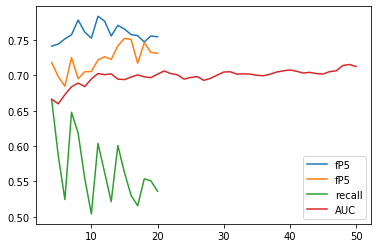

In [221]:
plt.plot(wKNN_GridSearch.cv_results_['param_wKNN__n_neighbors'].data, wKNN_GridSearch.cv_results_['mean_test_score'], label='fP5')
plt.plot(wKNNn_GridSearch.cv_results_['param_wKNNn__n_neighbors'].data, wKNNn_GridSearch.cv_results_['mean_test_score'], label='fP5')
plt.plot(wKNN4_GridSearch.cv_results_['param_wKNN__n_neighbors'].data, wKNN4_GridSearch.cv_results_['mean_test_score'], label='recall')
plt.plot(wKNN50_GridSearch.cv_results_['param_wKNN__n_neighbors'].data, wKNN50_GridSearch.cv_results_['mean_test_score'], label='AUC')
plt.legend()


In [222]:
# RF

n_estimators_range = np.linspace(80, 120, 3).astype(int)
min_samples_split_range = np.arange(.2,.32,.025)
min_samples_leaf_range = [8,10,12,15,20]#np.arange(.02,.1,.02)
min_weight_fraction_leaf = np.linspace(.02,.1,9)
max_features_range = np.linspace(1,7,7).astype(int)
max_features_range = np.linspace(1,6,6).astype(int)
param_grid = {'RF__n_estimators': n_estimators_range, 
              'RF__min_weight_fraction_leaf': min_weight_fraction_leaf,
              'RF__max_features': max_features_range}#,
              #'RF__max_samples': np.arange(.1,.91,.1)}#4d too expensive

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(recall_score)}

scorers = {'score': make_scorer(accuracy_score)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(weighted_accuracy)}

RF_GridSearch = GridSearchCV(estimator=PL_RF,
                             param_grid=param_grid,
                             scoring=scorers,
                             refit='score',
                             cv=5,
                             verbose=1,
                             n_jobs=1,
                             return_train_score=True)

RF_GridSearch.fit(ILPR_X, ILPR_Y)
RF_GridSearch.best_score_, RF_GridSearch.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  1.9min finished


(0.6769040899718208,
 {'RF__max_features': 1,
  'RF__min_weight_fraction_leaf': 0.09000000000000001,
  'RF__n_estimators': 100})

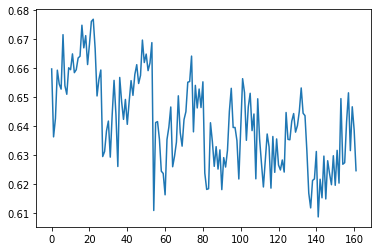

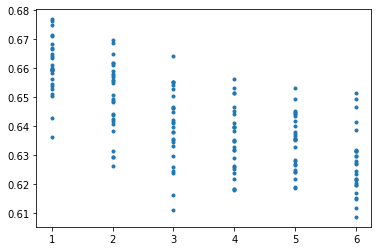

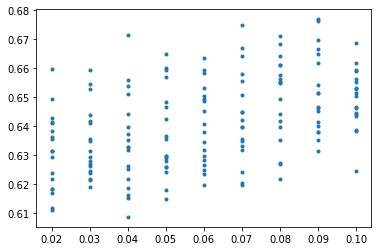

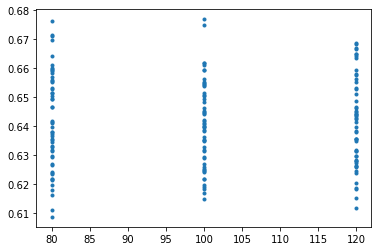

In [223]:
plt.plot(RF_GridSearch.cv_results_['mean_test_score'])
plt.show()
plt.plot(RF_GridSearch.cv_results_['param_RF__max_features'].data,
         RF_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()
plt.plot(RF_GridSearch.cv_results_['param_RF__min_weight_fraction_leaf'].data,
         RF_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()
plt.plot(RF_GridSearch.cv_results_['param_RF__n_estimators'].data,
         RF_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()



In [230]:
# SVM rbf kernel: weighted accueracy focussed

C_range = np.logspace(6, 13, 8, base=2)
gamma_range = np.logspace(-5, 0, 6)
gamma_range[-1] = 0.5
param_grid = {'SVM__C': C_range, 
              'SVM__gamma': gamma_range}

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(weighted_accuracy)}

SVM_GridSearch = GridSearchCV(estimator=PL_SVM, 
                              param_grid=param_grid, 
                              scoring=scorers, 
                              refit='score', 
                              cv=5, 
                              verbose=1,
                              n_jobs=1,
                              return_train_score=True)
SVM_GridSearch.fit(ILPR_X,  ILPR_Y)
SVM_GridSearch.best_score_, SVM_GridSearch.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   25.8s finished


(0.6952773613193404, {'SVM__C': 256.0, 'SVM__gamma': 0.0001})

In [229]:
# SVM rbf kernel: precsion focused

C_range = np.logspace(6, 13, 8, base=2)
gamma_range = np.logspace(-5, 0, 6)
gamma_range[-1] = 0.5
param_grid = {'SVM__C': C_range, 
              'SVM__gamma': gamma_range}

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'score': make_scorer(precision_score)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(fbeta_score, beta=.5)}# this favors precision over recall

SVMp_GridSearch = GridSearchCV(estimator=PL_SVM, 
                              param_grid=param_grid, 
                              scoring=scorers, 
                              refit='score', 
                              cv=5, 
                              verbose=1,
                              n_jobs=1,
                              return_train_score=True)
SVMp_GridSearch.fit(ILPR_X,  ILPR_Y)
SVMp_GridSearch.best_score_, SVMp_GridSearch.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   25.3s finished


(0.7560016202767629, {'SVM__C': 512.0, 'SVM__gamma': 0.01})

In [417]:
# SVM rbf kernel: recall focused
C_range = np.logspace(6, 11, 6, base=2)
np.logspace(-5, 11, 17, base=2)[-1]
gamma_range = np.logspace(-5, 0, 6)
gamma_range[-2] = 0.05
gamma_range[-1] = 0.1

param_grid = {'SVM__C': C_range, 
              'SVM__gamma': gamma_range}

scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'score': make_scorer(recall_score)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(fbeta_score, beta=.75)}# this 'less than 0.5' favors precision over recall

SVMr_GridSearch = GridSearchCV(estimator=PL_SVM, 
                              param_grid=param_grid, 
                              scoring=scorers, 
                              refit='score', 
                              cv=5, 
                              verbose=1,
                              n_jobs=1,
                              return_train_score=True)
SVMr_GridSearch.fit(ILPR_X,  ILPR_Y)
SVMr_GridSearch.best_score_, SVMr_GridSearch.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   13.8s finished


(0.6956682198842106, {'SVM__C': 1024.0, 'SVM__gamma': 0.05})

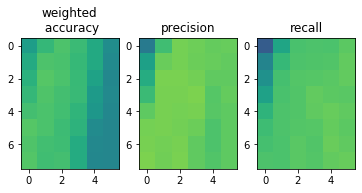

param_SVM__gamma,1e-05,0.0001,0.001,0.01,0.05,0.1
param_SVM__C,,,,,,
64.0,0.384425,0.577863,0.660941,0.666607,0.662743,0.683708
128.0,0.488869,0.632049,0.665689,0.669172,0.670419,0.690407
256.0,0.524460,0.654974,0.673143,0.676281,0.681987,0.692307
512.0,0.569335,0.660633,0.672074,0.692474,0.684145,0.680655
1024.0,0.619052,0.664674,0.670724,0.690015,0.695668,0.689362
2048.0,0.644827,0.665659,0.674855,0.677072,0.693160,0.683141
4096.0,0.656592,0.662353,0.680843,0.671012,0.698970,0.687946
8192.0,0.666210,0.662703,0.682456,0.674653,0.692156,0.696753


In [231]:

fig,ax=plt.subplots(1,3)

df = pd.DataFrame(
{'mean_test_score':SVM_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVM_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__gamma':SVM_GridSearch.cv_results_['param_SVM__gamma']})

ax[0].imshow(pd.pivot_table(df, values='mean_test_score',
                       index='param_SVM__C',
                       columns='param_SVM__gamma'), vmax=(df.mean_test_score.max()+1)/2, 
                                                    vmin=df.mean_test_score.min()/2)
ax[0].set_title('weighted\n accuracy')

df = pd.DataFrame(
{'mean_test_score':SVMp_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVMp_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__gamma':SVMp_GridSearch.cv_results_['param_SVM__gamma']})

ax[1].imshow(pd.pivot_table(df, values='mean_test_score',
                       index='param_SVM__C',
                       columns='param_SVM__gamma'), vmax=(df.mean_test_score.max()+1)/2, 
                                                    vmin=df.mean_test_score.min()/2)
ax[1].set_title('precision')

df = pd.DataFrame(
{'mean_test_score':SVMr_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVMr_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__gamma':SVMr_GridSearch.cv_results_['param_SVM__gamma']})

ax[2].imshow(pd.pivot_table(df, values='mean_test_score',
                       index='param_SVM__C',
                       columns='param_SVM__gamma'), vmax=(df.mean_test_score.max()+1)/2, 
                                                    vmin=df.mean_test_score.min()/2)
ax[2].set_title('recall')

plt.show()

display(pd.pivot_table(df, values='mean_test_score',
                       index='param_SVM__C',
                       columns='param_SVM__gamma'))



In [265]:
# SVM polynomial kernel: weighted accuracy

C_range = np.logspace(-5, 13, 19, base=2)
degree_range = np.linspace(1, 5, 5).astype(int)
param_grid = {'SVM__kernel': ['poly'],
              'SVM__C': C_range, 
              'SVM__degree': degree_range}
scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(accuracy_score)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'score': make_scorer(precision_score)}
scorers = {'score': make_scorer(recall_score)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(weighted_accuracy)}

SVM_2_GridSearch = GridSearchCV(estimator=PL_SVM,
                                param_grid=param_grid,
                                scoring=scorers,
                                refit='score',
                                cv=5,
                                verbose=1,
                                n_jobs=1,
                                return_train_score=True)
SVM_2_GridSearch.fit(ILPR_X, ILPR_Y)
SVM_2_GridSearch.best_score_, SVM_2_GridSearch.best_params_

Fitting 5 folds for each of 95 candidates, totalling 475 fits


[Parallel(n_jobs=1)]: Done 475 out of 475 | elapsed:  2.5min finished


(0.6952773613193404, {'SVM__C': 0.5, 'SVM__degree': 1, 'SVM__kernel': 'poly'})

In [398]:
# SVM polynomial kernel: recal focused

C_range = np.logspace(-5, 11, 17, base=2)
degree_range = np.linspace(1, 5, 5).astype(int)
param_grid = {'SVM__kernel': ['poly'],
              'SVM__C': C_range, 
              'SVM__degree': degree_range}
scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(accuracy_score)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'score': make_scorer(precision_score)}
scorers = {'score': make_scorer(recall_score)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(fbeta_score, beta=.5)}

SVMp_2_GridSearch = GridSearchCV(estimator=PL_SVM,
                                param_grid=param_grid,
                                scoring=scorers,
                                refit='score',
                                cv=5,
                                verbose=1,
                                n_jobs=1,
                                return_train_score=True)
SVMp_2_GridSearch.fit(ILPR_X, ILPR_Y)
SVMp_2_GridSearch.best_score_, SVMp_2_GridSearch.best_params_

Fitting 5 folds for each of 85 candidates, totalling 425 fits


[Parallel(n_jobs=1)]: Done 425 out of 425 | elapsed:   43.8s finished


(0.7563781496259125,
 {'SVM__C': 128.0, 'SVM__degree': 1, 'SVM__kernel': 'poly'})

In [407]:
# SVM polynomial kernel: precision focused

np.logspace(-5, 8, 14, base=2)
degree_range = np.linspace(1, 5, 5).astype(int)
param_grid = {'SVM__kernel': ['poly'],
              'SVM__C': C_range, 
              'SVM__degree': degree_range}
scorers = {'score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'score': make_scorer(accuracy_score)}
scorers = {'score': make_scorer(weighted_accuracy)}
scorers = {'score': make_scorer(precision_score)}
scorers = {'score': make_scorer(recall_score)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(recall_score)}

SVMr_2_GridSearch = GridSearchCV(estimator=PL_SVM,
                                param_grid=param_grid,
                                scoring=scorers,
                                refit='score',
                                cv=5,
                                verbose=1,
                                n_jobs=1,
                                return_train_score=True)
SVMr_2_GridSearch.fit(ILPR_X, ILPR_Y)
SVMr_2_GridSearch.best_score_, SVMr_2_GridSearch.best_params_

Fitting 5 folds for each of 85 candidates, totalling 425 fits


[Parallel(n_jobs=1)]: Done 425 out of 425 | elapsed:   44.9s finished


(0.6245098039215686,
 {'SVM__C': 2048.0, 'SVM__degree': 4, 'SVM__kernel': 'poly'})

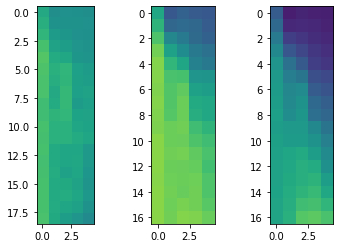

In [408]:
fig,ax = plt.subplots(1,3)

df = pd.DataFrame(
{'mean_test_score':SVM_2_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVM_2_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__degree':SVM_2_GridSearch.cv_results_['param_SVM__degree']})

ax[0].imshow(pd.pivot_table(df, values='mean_test_score',
                          index='param_SVM__C',
                          columns='param_SVM__degree'), vmax=(df.mean_test_score.max()+1)/2, 
                                                        vmin=df.mean_test_score.min()/2)

df = pd.DataFrame(
{'mean_test_score':SVMp_2_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVMp_2_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__degree':SVMp_2_GridSearch.cv_results_['param_SVM__degree']})

ax[1].imshow(pd.pivot_table(df, values='mean_test_score',
                          index='param_SVM__C',
                          columns='param_SVM__degree'), vmax=(df.mean_test_score.max()+1)/2, 
                                                        vmin=df.mean_test_score.min()/2)

df = pd.DataFrame(
{'mean_test_score':SVMr_2_GridSearch.cv_results_['mean_test_score'],
 'param_SVM__C':SVMr_2_GridSearch.cv_results_['param_SVM__C'],
 'param_SVM__degree':SVMr_2_GridSearch.cv_results_['param_SVM__degree']})

ax[2].imshow(pd.pivot_table(df, values='mean_test_score',
                          index='param_SVM__C',
                          columns='param_SVM__degree'), vmax=(df.mean_test_score.max()+1)/2, 
                                                        vmin=df.mean_test_score.min()/2)


In [308]:
# LR

C_range = np.logspace(-3, 1, 5)
l1_ratio_range = np.linspace(0,1,11)
n_components_range = [1,2,3,4,5,6,7]#[1,2,3]#
degree_range = [1,2]

param_grid = {'LR__C': C_range, 
              'LR__l1_ratio': l1_ratio_range,
              'X__Cont_ImputeScaleStandardizePCA__PCA__n_components': n_components_range,
              'X__Cont_ImputeScaleStandardizePCA__HigherOrderTerms__degree': degree_range}

scorers = {'auc_score': make_scorer(roc_auc_score, needs_proba=True)}
scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(weighted_accuracy)}

LR_GridSearch = GridSearchCV(estimator=PL_LR, 
                              param_grid=param_grid, 
                              scoring=scorers, 
                              refit='score', 
                              cv=5, 
                              verbose=1,
                              n_jobs=1,
                              return_train_score=True)

LR_GridSearch.fit(ILPR_X, ILPR_Y)
LR_GridSearch.best_score_, LR_GridSearch.best_params_

Fitting 5 folds for each of 770 candidates, totalling 3850 fits


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

(0.6975558439267762,
 {'LR__C': 0.1,
  'LR__l1_ratio': 0.0,
  'X__Cont_ImputeScaleStandardizePCA__HigherOrderTerms__degree': 1,
  'X__Cont_ImputeScaleStandardizePCA__PCA__n_components': 5})

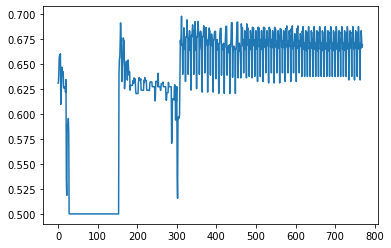

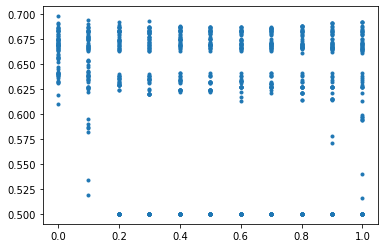

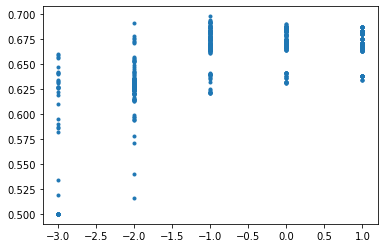

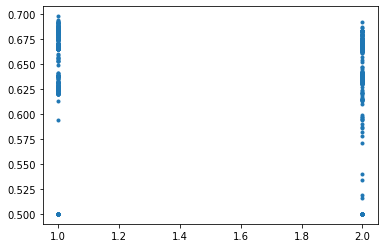

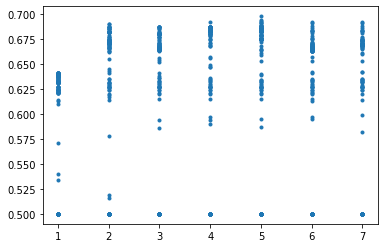

In [309]:
plt.plot(LR_GridSearch.cv_results_['mean_test_score'])
plt.show()
plt.plot(LR_GridSearch.cv_results_['param_LR__l1_ratio'].data,
         LR_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()
plt.plot(np.log10(LR_GridSearch.cv_results_['param_LR__C'].data.astype(float)),
         LR_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()
plt.plot(LR_GridSearch.cv_results_['param_X__Cont_ImputeScaleStandardizePCA__HigherOrderTerms__degree'].data,
         LR_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()
plt.plot(LR_GridSearch.cv_results_['param_X__Cont_ImputeScaleStandardizePCA__PCA__n_components'].data,
         LR_GridSearch.cv_results_['mean_test_score'],'.')
plt.show()



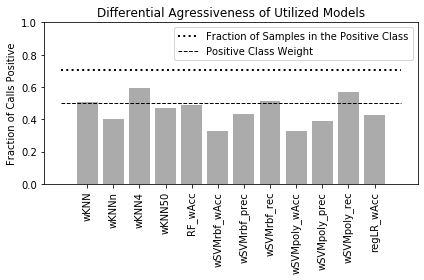

In [422]:
grids = [
    ('wKNN', wKNN_GridSearch),
    ('wKNNn', wKNNn_GridSearch),
    ('wKNN4', wKNN4_GridSearch),
    ('wKNN50', wKNN50_GridSearch),
    ('RF_wAcc', RF_GridSearch),
    ('wSVMrbf_wAcc', SVM_GridSearch),
    ('wSVMrbf_prec', SVMp_GridSearch),
    ('wSVMrbf_rec', SVMr_GridSearch),
    ('wSVMpoly_wAcc', SVM_2_GridSearch),
    ('wSVMpoly_prec', SVMp_2_GridSearch),
    ('wSVMpoly_rec', SVMr_2_GridSearch),
    ('regLR_wAcc',LR_GridSearch)
]

plt.ylim([0,1])

plt.plot([-1,len(grids)], [ILPR_Y.mean()]*2, 'k:', label='Fraction of Samples in the Positive Class', linewidth=2)
plt.plot([-1,len(grids)], [.5]*2, 'k--', label='Positive Class Weight', linewidth=1)
plt.bar(height=[g.best_estimator_.predict(ILPR_X).mean() for i,g in grids], 
        x=range(len(grids)), color='gray', alpha=0.66)
plt.xticks(range(len(grids)),[i for i,g in grids], rotation=90)
plt.ylabel('Fraction of Calls Positive')
plt.title('Differential Agressiveness of Utilized Models')
plt.legend()
plt.tight_layout()
plt.savefig('agressiveness.png')

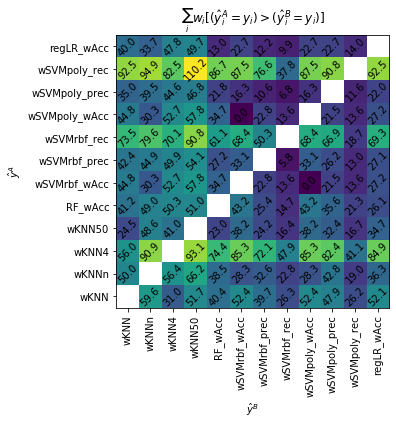

In [423]:
weights = .5*ILPR_Y/ILPR_Y.mean() + .5*(1-ILPR_Y)/(1-ILPR_Y.mean())

yhats = np.zeros([ILPR_X.shape[0],len(grids)])
for i,(name,grid) in enumerate(grids):
    yhats[:,i] = grid.best_estimator_.predict(ILPR_X)

overlap = np.zeros([len(grids),len(grids)])*np.nan
for i in range(len(grids)-1):
    for j in range(i+1,len(grids)):
        overlap[i,j] = (weights * ((yhats[:,i]==ILPR_Y).astype(int)>\
                                   (yhats[:,j]==ILPR_Y).astype(int))).sum()
        overlap[i,j] = np.round(overlap[i,j],1)
        overlap[j,i] = (weights * ((yhats[:,i]==ILPR_Y).astype(int)<\
                                   (yhats[:,j]==ILPR_Y).astype(int))).sum()
        overlap[j,i] = np.round(overlap[j,i],1)
        
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(overlap)

ax.set_yticks(range(overlap.shape[1]))
ax.set_yticklabels([i for i,j in grids])
ax.set_xticks(range(overlap.shape[1]))
ax.set_xticklabels([i for i,j in grids], rotation=90)
ax.set_ylim([-.5,overlap.shape[1]-.5])
ax.set_xlim([-.5,overlap.shape[1]-.5])
ax.set_ylabel('$\hat y^A$')
ax.set_xlabel('$\hat y^B$')
ax.set_title('$\sum_i w_i[(\hat y^A_i = y_i) > (\hat y^B_i = y_i)]$')

for i in range(len(grids)):
    for j in range(len(grids)):
        if i!=j:
            plt.text(j,i,overlap[i,j],rotation=45,
                     verticalalignment='center',horizontalalignment='center')

plt.tight_layout()
#plt.savefig('prediction_diversity.png')
# This plot shows number of samples the row model
# calls correctly when the column model doesn't
# It gives an idea of the degree of complementarity 
# that might exist between the various models 

In [442]:

ensemble = [(i,g.best_estimator_) for i,g in grids[:12]]

#final_estimator is trained on out-samples using sklearn.model_selection.cross_val_predict
stack = StackingClassifier(estimators=ensemble, 
                           stack_method='predict',
                           passthrough=False,
                           final_estimator=RandomForestClassifier(class_weight='balanced_subsample'))#.fit(ILPR_X, ILPR_Y)

scorers = {'weighted_accuracy': make_scorer(weighted_accuracy),
           'accuracy': make_scorer(accuracy_score),
           'score': make_scorer(weighted_accuracy)}

final = GridSearchCV(estimator=stack,
                     param_grid={'final_estimator__class_weight': ['balanced_subsample']},
                     #param_grid={'final_estimator__min_weight_fraction_leaf': [8/483,16/483,32/483],
                     #            'final_estimator__n_estimators': [1,2,3,5,10],
                     #            'final_estimator__max_features': [5,6]},
                     scoring=scorers,refit='score',
                     cv=5, verbose=1, n_jobs=1).fit(ILPR_X, ILPR_Y)

final.best_score_, final.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] final_estimator__class_weight=balanced_subsample ................
[CV] . final_estimator__class_weight=balanced_subsample, total=   3.5s
[CV] final_estimator__class_weight=balanced_subsample ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] . final_estimator__class_weight=balanced_subsample, total=   3.0s
[CV] final_estimator__class_weight=balanced_subsample ................
[CV] . final_estimator__class_weight=balanced_subsample, total=   3.3s
[CV] final_estimator__class_weight=balanced_subsample ................
[CV] . final_estimator__class_weight=balanced_subsample, total=   3.2s
[CV] final_estimator__class_weight=balanced_subsample ................
[CV] . final_estimator__class_weight=balanced_subsample, total=   3.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s finished


(0.6733215325110555, {'final_estimator__class_weight': 'balanced_subsample'})

In [455]:

#final_estimator is trained on out-samples using sklearn.model_selection.cross_val_predict
stackX = StackingClassifier(estimators=ensemble, 
                            stack_method='predict',
                            passthrough=True,
                            final_estimator=RandomForestClassifier(class_weight='balanced_subsample'))#.fit(ILPR_X, ILPR_Y)

finalX = GridSearchCV(estimator=stackX,
                     param_grid={'final_estimator__class_weight': ['balanced_subsample']},
                     scoring=scorers,refit='score',
                     cv=5, verbose=1, n_jobs=1).fit(ILPR_X, ILPR_Y)

finalX.best_score_, finalX.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.3s finished


(0.551635526774428, {'final_estimator__class_weight': 'balanced_subsample'})

In [456]:

#final_estimator is trained on out-samples using sklearn.model_selection.cross_val_predict
stack2 = StackingClassifier(estimators=ensemble, 
                            stack_method='predict_proba',
                            passthrough=False,
                            final_estimator=RandomForestClassifier(class_weight='balanced_subsample'))#.fit(ILPR_X, ILPR_Y)

final2 = GridSearchCV(estimator=stack2,
                     param_grid={'final_estimator__class_weight': ['balanced_subsample']},
                     scoring=scorers,refit='score',
                     cv=5, verbose=1, n_jobs=1).fit(ILPR_X, ILPR_Y)

final2.best_score_, final2.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s finished


(0.5469118381985478, {'final_estimator__class_weight': 'balanced_subsample'})

In [443]:
grids = grids[:12]
grids += [('voting', final)]
grids += [('voting+X', finalX)]
grids += [('stacked predict_proba', final2)]

kfolds_auc = []
kfolds_auc_sd = []
WIP_auc = []
FHO_auc = []
for i,(name,grid) in enumerate(grids):
    kfolds_auc += [grid.cv_results_['mean_test_weighted_accuracy'][grid.best_index_]]
    kfolds_auc_sd += [grid.cv_results_['std_test_weighted_accuracy'][grid.best_index_]]
    WIP_auc += [roc_auc_score(ILPR_Y, grid.best_estimator_.predict_proba(ILPR_X)[:,1])]
    FHO_auc += [roc_auc_score(ILPR_Y_FHO, grid.best_estimator_.predict_proba(ILPR_X_FHO)[:,1])]
    print(name,"auc's",
          'kfolds', kfolds_auc[-1],
          'WIP', WIP_auc[-1],
          'FHO', FHO_auc[-1])

wKNN auc's kfolds 0.6782515254977554 WIP 0.8002664078311511 FHO 0.7096
wKNNn auc's kfolds 0.6579335332333833 WIP 0.7409545248027756 FHO 0.7143999999999999
wKNN4 auc's kfolds 0.5962407451736317 WIP 0.8608277229358556 FHO 0.6983999999999999
wKNN50 auc's kfolds 0.6615449628127114 WIP 0.73657634959316 FHO 0.7352
RF_wAcc auc's kfolds 0.6769040899718208 WIP 0.8003180372557928 FHO 0.7615999999999999
wSVMrbf_wAcc auc's kfolds 0.6952773613193404 WIP 0.7545124117136839 FHO 0.7917333333333333
wSVMrbf_prec auc's kfolds 0.6602904430137871 WIP 0.8324418652678534 FHO 0.7485333333333333
wSVMrbf_rec auc's kfolds 0.6200484841612808 WIP 0.9097104621866093 FHO 0.7258666666666667
wSVMpoly_wAcc auc's kfolds 0.6952773613193404 WIP 0.7542439387055473 FHO 0.7914666666666667
wSVMpoly_prec auc's kfolds 0.6804568304083253 WIP 0.774751146173227 FHO 0.7424
wSVMpoly_rec auc's kfolds 0.6145948034386168 WIP 0.9498575027879889 FHO 0.6746666666666667
regLR_wAcc auc's kfolds 0.6975558439267762 WIP 0.751373342695469 FHO 0

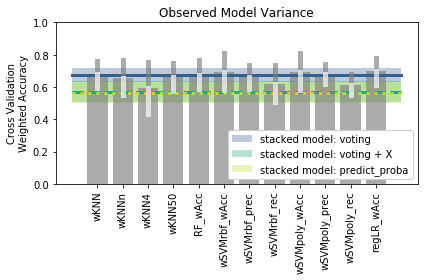

In [444]:
plt.ylim([0,1])

plt.bar(height=kfolds_auc[:-3], x=range(1,len(kfolds_auc)-2), 
        color='gray', alpha=0.66)
_=plt.xticks(range(1,len(kfolds_auc)-2),[i for i,j in grids[:-3]], rotation=90)

col = plt.cm.viridis(.3)
plt.plot([0,len(kfolds_auc)-2],[kfolds_auc[-3]]*2,linewidth=3, c=col)
plt.fill_between(y1=kfolds_auc[-3]+2*kfolds_auc_sd[-3],
                 y2=kfolds_auc[-3]-2*kfolds_auc_sd[-3],
                 x=range(0,len(kfolds_auc)-1), 
                 facecolor=col, alpha=0.33, label='stacked model: voting')

col = plt.cm.viridis(.6)
plt.plot([0,len(kfolds_auc)-2],[kfolds_auc[-2]]*2,'--',linewidth=3, c=col)
plt.fill_between(y1=kfolds_auc[-2]+2*kfolds_auc_sd[-2],
                 y2=kfolds_auc[-2]-2*kfolds_auc_sd[-2],
                 x=range(0,len(kfolds_auc)-1), 
                 facecolor=col, alpha=0.33, label='stacked model: voting + X')

col = plt.cm.viridis(.9)
plt.plot([0,len(kfolds_auc)-2],[kfolds_auc[-1]]*2,':',linewidth=3, c=col)
plt.fill_between(y1=kfolds_auc[-1]+2*kfolds_auc_sd[-1],
                 y2=kfolds_auc[-1]-2*kfolds_auc_sd[-1],
                 x=range(0,len(kfolds_auc)-1), 
                 facecolor=col, alpha=.33, label='stacked model: predict_proba')



for i in range(len(grids)-3):
    plt.plot([i+1]*2, [kfolds_auc[i]+2*kfolds_auc_sd[i],
                       kfolds_auc[i]], c='gray', linewidth=5, alpha=.66)
    plt.plot([i+1]*2, [kfolds_auc[i]-2*kfolds_auc_sd[i],
                       kfolds_auc[i]], c='w', linewidth=5, alpha=.66)
        
plt.ylabel('Cross Validation\nWeighted Accuracy')
plt.title('Observed Model Variance')
plt.legend(loc='lower right', framealpha=1)

plt.tight_layout()
#plt.savefig('model_var.png')

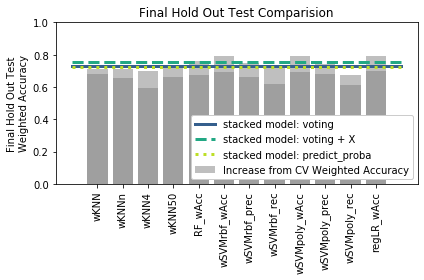

In [445]:
plt.ylim([0,1])
plt.bar(height=FHO_auc[:-3], x=range(1,len(FHO_auc)-2), 
        color='gray', alpha=0.5)
plt.bar(height=kfolds_auc[:-3], x=range(1,len(kfolds_auc)-2), 
        color='gray', alpha=0.5, label='Increase from CV Weighted Accuracy')

col = plt.cm.viridis(.3)
plt.plot([0,len(FHO_auc)-2],[FHO_auc[-3]]*2,linewidth=3, c=col, label='stacked model: voting')

col = plt.cm.viridis(.6)
plt.plot([0,len(FHO_auc)-2],[FHO_auc[-2]]*2,'--',linewidth=3, c=col, label='stacked model: voting + X')

col = plt.cm.viridis(.9)
plt.plot([0,len(FHO_auc)-2],[FHO_auc[-1]]*2,':',linewidth=3, c=col, label='stacked model: predict_proba')

_=plt.xticks(range(1,len(FHO_auc)-2),[i for i,j in grids[:-3]], rotation=90)


plt.ylabel('Final Hold Out Test\nWeighted Accuracy')
plt.title('Final Hold Out Test Comparision')
plt.legend(loc='lower right', framealpha=1)

plt.tight_layout()
plt.savefig('model_fho.png')

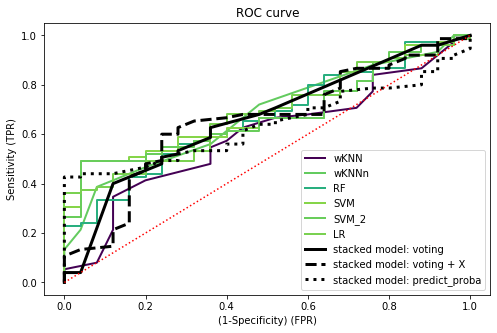

In [72]:
plt.figure(figsize=(8,5))

for i,(name,grid) in enumerate(grids[:-3]):

    fpr, tpr, thresholds = roc_curve(ILPR_Y_FHO, grid.best_estimator_.predict_proba(ILPR_X_FHO)[:,1])
    col = (FHO_auc[i]-min(FHO_auc[:-1]))/(.02+max(FHO_auc[:-1])-min(FHO_auc[:-1]))
    plt.plot(fpr,tpr,label=name,c=plt.cm.viridis(col),linewidth=2)

fpr, tpr, thresholds = roc_curve(ILPR_Y_FHO, grids[-3][-1].best_estimator_.predict_proba(ILPR_X_FHO)[:,1])
plt.plot(fpr,tpr,label='stacked model: voting',c='k',linewidth=3)
fpr, tpr, thresholds = roc_curve(ILPR_Y_FHO, grids[-2][-1].best_estimator_.predict_proba(ILPR_X_FHO)[:,1])
plt.plot(fpr,tpr,'--',label='stacked model: voting + X',c='k',linewidth=3)
fpr, tpr, thresholds = roc_curve(ILPR_Y_FHO, grids[-1][-1].best_estimator_.predict_proba(ILPR_X_FHO)[:,1])
plt.plot(fpr,tpr,':',label='stacked model: predict_proba',c='k',linewidth=3)
    
plt.plot([0,1],[0,1],'r:')

plt.legend()
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('(1-Specificity) (FPR)')
plt.title('ROC curve')

#plt.savefig('roc.png')

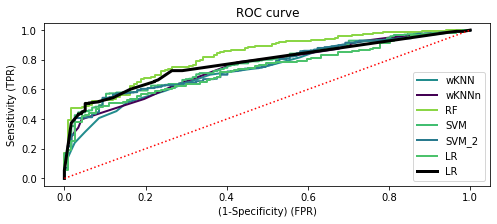

In [84]:
plt.figure(figsize=(8,3))

for i,(name,grid) in enumerate(grids[:-1]):

    fpr, tpr, thresholds = roc_curve(ILPR_Y, grid.best_estimator_.predict_proba(ILPR_X)[:,1])
    col = (auc[i]-min(auc[:-1]))/(.02+max(auc[:-1])-min(auc[:-1]))
    plt.plot(fpr,tpr,label=name,c=plt.cm.viridis(col),linewidth=2)

fpr, tpr, thresholds = roc_curve(ILPR_Y, grids[-1][-1].best_estimator_.predict_proba(ILPR_X)[:,1])
plt.plot(fpr,tpr,label=name,c='k',linewidth=3)
    
plt.plot([0,1],[0,1],'r:')

plt.legend()
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('(1-Specificity) (FPR)')
plt.title('ROC curve')

plt.savefig('roc.png')

- Note: 

| |t|f||
|-|-|-|-|
|T|TP|FN|TPR = TP/(TP+FN)|
|F|FP|TN|FPR = FP/(FP+TN)|

## 11. Justify the selection of specific classifiers used in the ensemble

- KNN scaled - nearest neighbors, all axes equal
- KNN unscaled - nearest neighbors, axes weight inverse of variance
- RF - a better nearest neighbors partitioner, with distance driven by outcome (via recursive partitioning)
    - and of course we have nice expected clt-like model-behavior (via bagging on cripled models)
- SVM radial basis function kernel - non-linear classification boundary generator
- SVM polynomial kernel - another non-linear classification emphesizing boundary generation
- LR - provides some potential for interpretation if we wished, but for the purposes here this was mostly included as a low complexity model; however, unexpectly and interestingly, with the PCA this was one of the more noteworthy performers...  

### and then I threw in a bunch more for kicks
- tried to make these a different as possible and did so through various techniques for different model classes

## 12. Present your work and conclusions in a documented with Markdown Jupyter notebook, as well as in a pdf report
- That's this, and in the doc you've been sent